In [46]:
import pandas as pd
import numpy as np
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# BTC

In [127]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

### ADX calculation
Below 20: Indicates a weak trend or a ranging market. The asset is likely moving sideways, and trading strategies that depend on trend-following may be less effective. <br>
20 to 25: Indicates a potential emerging trend. Traders may begin to look for signals to enter positions. <br>
25 to 40: Indicates a strengthening trend. This is often where trend-following strategies can be more effective. Depending on the asset, this could be considered a moderately strong trend. <br>
40 to 60: Indicates a strong trend. Here, the asset is trending strongly in one direction, making it more suitable for trend-following strategies. <br>
Above 60: Indicates an extremely strong trend, which might also signal an overbought or oversold condition, suggesting potential reversals. <br>

In [128]:
# Calculate lagged prices
btc['PrevHigh'] = btc['High'].shift(1)
btc['PrevLow'] = btc['Low'].shift(1)
btc['PrevClose'] = btc['Close'].shift(1)

# Calculate true range component
btc['TR1'] = btc['High'] - btc['Low']
btc['TR2'] = abs(btc['High'] - btc['PrevClose'])
btc['TR3'] = abs(btc['Low'] - btc['PrevClose'])

# Calculate true range as the max of the three TRs
btc['TR'] = btc[['TR1', 'TR2', 'TR3']].max(axis=1)
btc.at[btc.index[0], 'TR'] = np.nan

In [129]:
# Initialize +DM and -DM columns
btc['+DM'] = 0.0
btc['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(btc)):
    high_diff = btc['High'].iloc[i] - btc['PrevHigh'].iloc[i]
    low_diff = btc['PrevLow'].iloc[i] - btc['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        btc.at[btc.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        btc.at[btc.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
btc['TR_smooth'] = btc['TR'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

btc['+DM_smooth'] = btc['+DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '+DM_smooth'] = np.nan
btc['-DM_smooth'] = btc['-DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
btc['+DI'] = (btc['+DM_smooth'] / btc['TR_smooth']) * 100
btc['-DI'] = (btc['-DM_smooth'] / btc['TR_smooth']) * 100

# Calculate DX and ADX
btc['DX'] = (abs(btc['+DI'] - btc['-DI']) / (btc['+DI'] + btc['-DI'])) * 100
btc['ADX'] = btc['DX'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [130]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Separate gains and losses
btc['Gain'] = btc['PriceChange'].where(btc['PriceChange'] > 0, 0)
btc['Loss'] = -btc['PriceChange'].where(btc['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

btc.loc[btc.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator
Varies from value of 0 to 100, the bounds of 80 and 20 are frequently taken as overbought and oversold levels

In [131]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

### MACD

In [132]:
btc['EMA_6'] = btc['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

### Breaking of 2 consecutive high

In [133]:
btc['PrevHigh2'] = btc['High'].shift(2)
btc['BreakHigh2'] = (btc['High'] > btc['PrevHigh']) & (btc['PrevHigh'] > btc['PrevHigh2'])

In [134]:
btc['TROpen'] = btc['Open'].diff()
btc['TRHigh'] = btc['High'].diff()
btc['TRLow'] = btc['Low'].diff()
btc['TRClose'] = btc['Close'].diff()
btc['TRShort_SMA'] = btc['SMAVG (5)  on Close'].diff()
btc['TRLong_SMA'] = btc['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
btc['Short_EMA'] = btc['Close'].ewm(span=5, adjust=False).mean()
btc['Long_EMA'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['TRShort_EMA'] = btc['Short_EMA'].diff()
btc['TRLong_EMA'] = btc['Long_EMA'].diff()

btc['DayOfWeek'] = btc['Date'].dt.dayofweek

#calculate returns
btc["returns"] = (btc["Close"] - btc["Open"])/btc["Open"]
btc["log_returns"] = np.log(btc['Close'] / btc['Open'])

### Final BTC data 

In [135]:
btc = btc.drop(columns=['High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
btc.drop(index=btc.index[:20], inplace=True)
btc

,Date,Open,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek,returns,log_returns
20,2024-01-01 10:00:00,42599.91,42535.88,34.638980,46.213708,68.685093,71.478756,11.198485,False,115.85,-120.74,37.03,-64.03,51.21,-7.52,17.240130,12.363108,0,-0.001503,-0.001504
21,2024-01-01 10:30:00,42535.88,42573.60,35.421038,53.400626,74.354119,73.782507,20.190863,False,-64.03,-25.50,-21.64,37.72,32.20,6.33,24.066754,16.973452,0,0.000887,0.000886
22,2024-01-01 11:00:00,42573.60,42430.38,31.442584,44.126566,52.829253,65.289488,5.852152,False,37.72,-15.98,-72.83,-143.22,-6.96,-12.13,-31.695498,-12.152630,0,-0.003364,-0.003370
23,2024-01-01 11:30:00,42430.38,42330.18,30.377071,53.763073,37.769963,54.984445,-16.284526,False,-143.22,-129.37,-171.35,-100.20,-30.78,6.38,-54.530332,-28.161243,0,-0.002362,-0.002364
24,2024-01-01 12:00:00,42330.18,42304.46,30.768291,57.753855,33.904444,41.501220,-32.339681,False,-100.20,-77.53,-41.89,-25.72,-59.09,12.23,-44.926888,-27.717381,0,-0.000608,-0.000608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20950,2025-03-12 14:30:00,81681.22,81422.27,43.747651,8.776190,5.883332,10.480370,-260.187689,False,-282.64,-209.00,-212.06,-256.28,-88.52,-187.74,-152.305616,-122.716529,2,-0.003170,-0.003175
20951,2025-03-12 15:00:00,81422.27,81672.17,44.822514,23.382916,16.022949,10.102204,-234.764535,False,-258.95,72.44,26.21,249.90,-18.37,-102.39,-18.237077,-54.968069,2,0.003069,0.003064
20952,2025-03-12 15:30:00,81672.17,82400.11,40.067170,49.593626,55.367956,25.758079,-113.087485,True,249.90,661.42,261.35,727.94,124.12,-1.93,230.488615,87.378853,2,0.008913,0.008873
20953,2025-03-12 16:00:00,82400.11,82485.61,39.182225,52.925797,79.819005,50.403303,-23.300806,True,727.94,302.40,454.42,85.50,104.35,13.96,182.159077,87.037243,2,0.001038,0.001037


### ADF Test

In [176]:
from statsmodels.tsa.stattools import adfuller
btc.dropna(inplace=True)
result = adfuller(btc['Close'])
result

#Open and Close prices are NOT stationary
#first difference Open and Close prices
btc["first_difference_open"] = btc["Open"].diff()
btc["first_difference_close"] = btc["Close"].diff()

# SPY

In [137]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

In [139]:
# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

### ADX

In [140]:
# Calculate lagged prices
spy['PrevHigh'] = spy['High'].shift(1)
spy['PrevLow'] = spy['Low'].shift(1)
spy['PrevClose'] = spy['Close'].shift(1)

# Calculate true range component
spy['TR1'] = spy['High'] - spy['Low']
spy['TR2'] = abs(spy['High'] - spy['PrevClose'])
spy['TR3'] = abs(spy['Low'] - spy['PrevClose'])

# Calculate true range as the max of the three TRs
spy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)
spy.at[spy.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
spy['+DM'] = 0.0
spy['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(spy)):
    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]
    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        spy.at[spy.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        spy.at[spy.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
spy['TR_smooth'] = spy['TR'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

spy['+DM_smooth'] = spy['+DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '+DM_smooth'] = np.nan
spy['-DM_smooth'] = spy['-DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
spy['+DI'] = (spy['+DM_smooth'] / spy['TR_smooth']) * 100
spy['-DI'] = (spy['-DM_smooth'] / spy['TR_smooth']) * 100

# Calculate DX and ADX
spy['DX'] = (abs(spy['+DI'] - spy['-DI']) / (spy['+DI'] + spy['-DI'])) * 100
spy['ADX'] = spy['DX'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [143]:
# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Separate gains and losses
spy['Gain'] = spy['PriceChange'].where(spy['PriceChange'] > 0, 0)
spy['Loss'] = -spy['PriceChange'].where(spy['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

spy.loc[spy.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator

In [145]:
k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()

### MACD

In [146]:
spy['EMA_6'] = spy['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

### Breaking of 2 consecutive highs

In [147]:
spy['PrevHigh2'] = spy['High'].shift(2)
spy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])

In [148]:
spy['TROpen'] = spy['Open'].diff()
spy['TRHigh'] = spy['High'].diff()
spy['TRLow'] = spy['Low'].diff()
spy['TRClose'] = spy['Close'].diff()
spy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()
spy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
spy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['TRShort_EMA'] = spy['Short_EMA'].diff()
spy['TRLong_EMA'] = spy['Long_EMA'].diff()

spy['DayOfWeek'] = spy['Date'].dt.dayofweek

#calculate returns
spy["returns"] = (spy["Close"] - spy["Open"])/spy["Open"]
spy["log_returns"] = np.log(spy['Close'] / spy['Open'])

### Final SPY data 

In [149]:
spy = spy.drop(columns=['High', 'Low', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'Volume', 'SMAVG (5)', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
spy.drop(index=spy.index[:20], inplace=True)
spy

,Date,Open,Close,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek,returns,log_returns
20,2024-01-04 02:00:00,470.330,470.350,18.975209,45.760234,41.414141,33.122214,-0.333418,True,0.770,0.380,0.842,0.035,0.190,-0.059,0.144235,0.013987,3,0.000043,0.000043
21,2024-01-04 02:30:00,470.345,470.080,16.859306,44.209040,34.595960,37.924936,-0.281867,False,0.015,-0.340,-0.403,-0.270,0.074,-0.082,0.006156,-0.037647,3,-0.000563,-0.000564
22,2024-01-04 03:00:00,470.080,471.015,18.382683,36.951317,58.207071,44.739057,-0.115023,False,-0.265,0.760,-0.910,0.935,0.347,-0.163,0.315771,0.139198,3,0.001989,0.001987
23,2024-01-04 03:30:00,471.020,470.221,19.629082,54.870822,38.156566,43.653199,-0.113831,False,0.940,-0.010,1.230,-0.794,0.130,0.041,-0.054153,-0.030475,3,-0.001696,-0.001698
24,2024-01-04 04:00:00,470.230,469.270,25.761205,47.731959,22.580645,39.648094,-0.233513,False,-0.790,-0.890,-1.210,-0.951,-0.209,-0.022,-0.353102,-0.197843,3,-0.002042,-0.002044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3863,2025-03-12 01:30:00,552.100,554.205,49.119195,33.055638,20.909091,9.505525,-1.887391,False,-2.180,1.035,-0.020,2.145,-0.597,-0.569,-0.146827,-0.407416,2,0.003813,0.003805
3864,2025-03-12 02:00:00,554.280,558.440,42.809022,44.663060,61.435407,27.512084,-1.116302,True,2.180,3.930,2.130,4.235,0.268,-0.217,1.313782,0.436660,2,0.007505,0.007477
3865,2025-03-12 02:30:00,558.440,561.450,42.239925,55.407883,86.912442,56.418980,-0.204267,True,4.160,3.550,3.190,3.010,1.080,0.236,1.879188,0.904540,2,0.005390,0.005376
3866,2025-03-12 03:00:00,561.420,559.647,42.922041,59.076472,63.558333,70.635394,0.118183,True,2.980,1.150,1.270,-1.803,1.083,0.371,0.651792,0.412260,2,-0.003158,-0.003163


In [ ]:
#Close and Open prices are NOT stationary
#first difference
spy["first_difference_open"] = spy["Open"].diff()
spy["first_difference_close"] = spy["Close"].diff()

In [181]:
#test for stationarity (ADF)
spy.dropna(inplace=True)
result = adfuller(spy['first_difference_close'])
result

(np.float64(-62.126740017277584),
 0.0,
 0,
 3837,
 {'1%': np.float64(-3.4320554157329366),
  '5%': np.float64(-2.862293559078938),
  '10%': np.float64(-2.5671711290285004)},
 np.float64(12744.392340934572))

In [ ]:
#check correlation between first difference of open and close prices (0.4, moderate)
correlation = spy["first_difference_open"].corr(spy["first_difference_close"])
print(correlation)

0.407513866862115


In [183]:
#check VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Selecting predictor variables
X = spy[["first_difference_open", "first_difference_close"]].dropna()  # Drop NaN values

# Adding a constant for intercept
X = sm.add_constant(X)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

#since VIF < 5, can include first difference of open and close prices as predictors


                  Feature       VIF
0                   const  1.000448
1   first_difference_open  1.199138
2  first_difference_close  1.199138


### Autocorrelation plot to determine the optimal number of lags for BTC and SPY

In [151]:
btc['Date'] = pd.to_datetime(btc['Date'])  # Convert to datetime
btc.set_index('Date', inplace=True)  # Set Date as index

spy['Date'] = pd.to_datetime(spy['Date'])  # Convert to datetime
spy.set_index('Date', inplace=True)  # Set Date as index

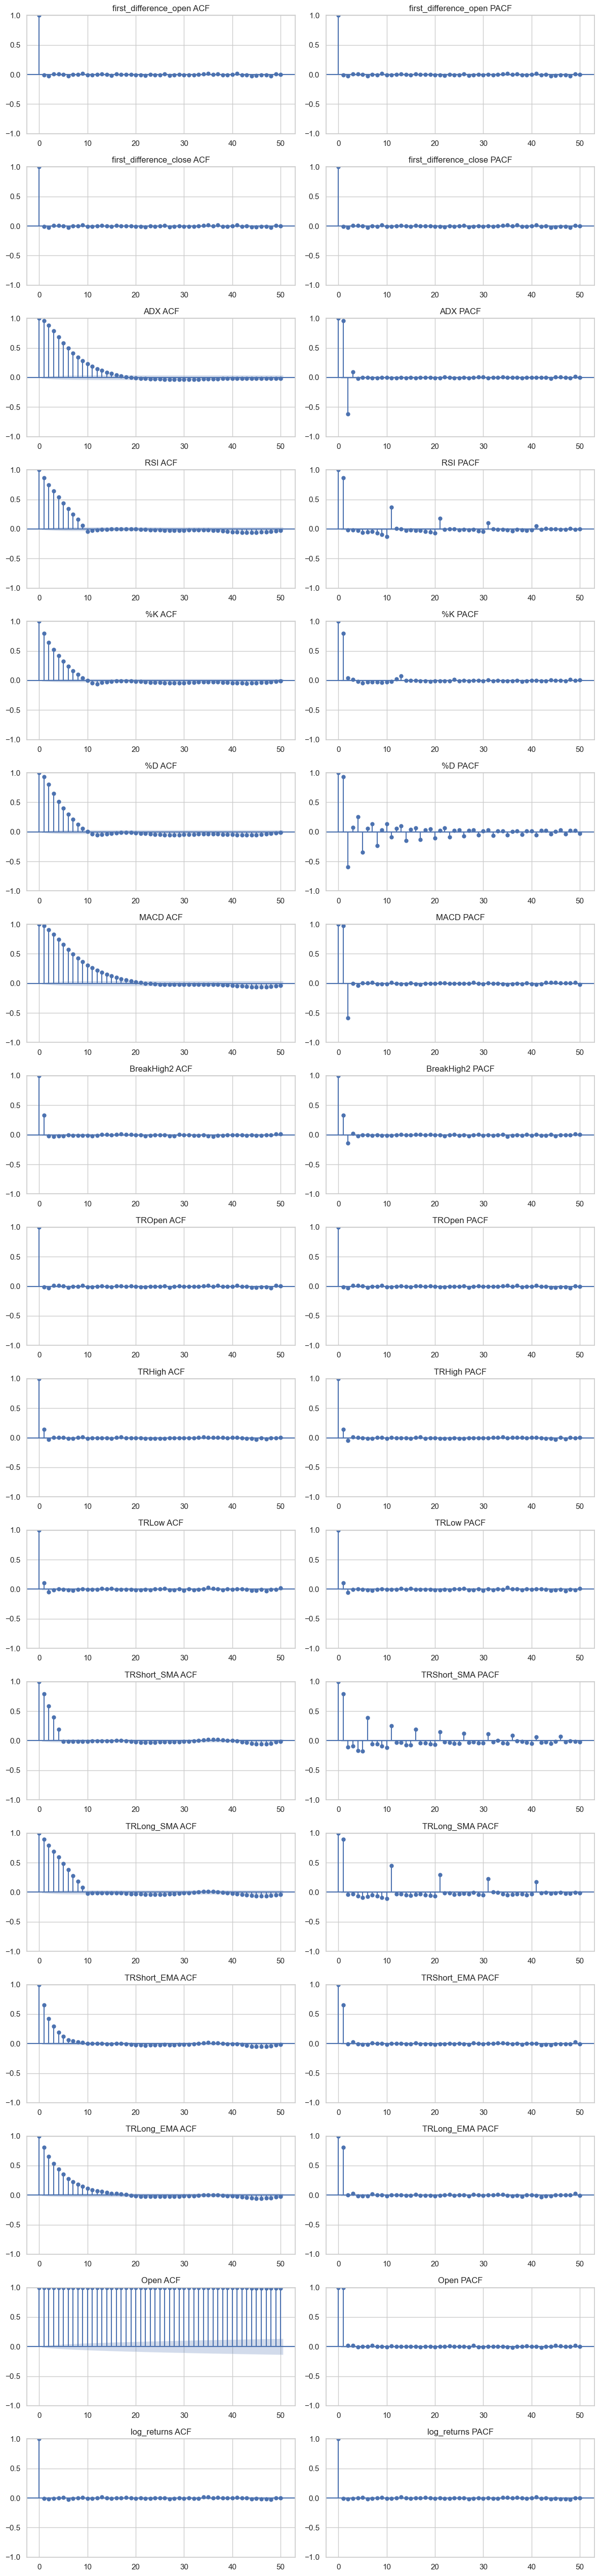

In [182]:
#plot the PACF for BTC
indicators = ['first_difference_open', 'first_difference_close', 'ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA', 'Open',  "log_returns"]

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(btc[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(btc[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()

In [ ]:
#check correlation between returns and log_returns
correlation = btc['returns'].corr(btc['log_returns'])
print(correlation)

#include either or bc high correlation (almost 1)

0.9999698201984917


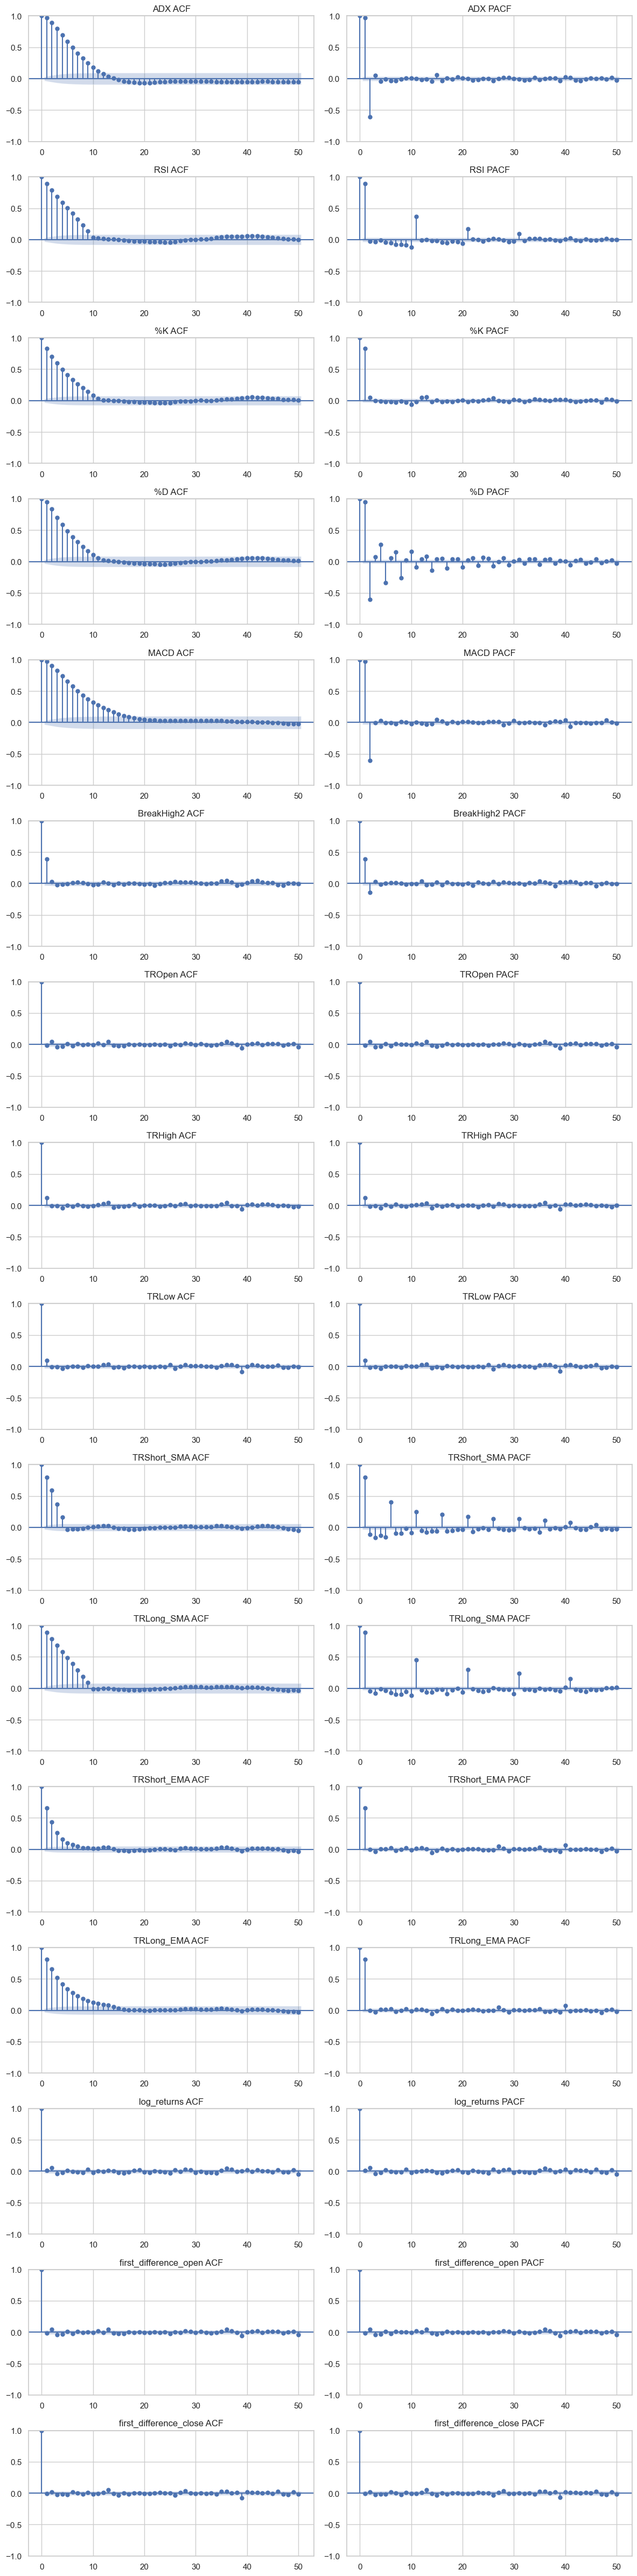

In [184]:
#plot the PACF for SPY
indicators = ['ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA', 'log_returns', 'first_difference_open','first_difference_close']

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(spy[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(spy[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()

In [185]:
# construct the lags for btc
# Dictionary of variables and their respective lag counts
lags = {
    'ADX': 3, 'RSI': 2, '%K': 2, '%D': 3, 'MACD': 3, 'BreakHigh2': 2,
    'TROpen': 1, 'TRHigh': 1, 'TRLow': 1, 'TRShort_SMA': 2, 'TRLong_SMA': 2,
    'TRShort_EMA': 2, 'TRLong_EMA': 2, 'first_difference_close': 1, "first_difference_open": 1, 'log_returns': 1
}

# Generate lagged features
for var, lag in lags.items():
    for i in range(1, lag + 1):
        btc[f'{var}_lag{i}'] = btc[var].shift(i)

#drop NA values
btc.dropna(inplace= True)
#calculate the number of observations (total)
num_observations_btc = len(btc)

In [186]:
# construct the lags for spy
# Dictionary of variables and their respective lag counts
lags = {
    'ADX': 3, 'RSI': 2, '%K': 2, '%D': 3, 'MACD': 3, 'BreakHigh2': 2,
    'TROpen': 1, 'TRHigh': 1, 'TRLow': 1, 'TRShort_SMA': 2, 'TRLong_SMA': 2,
    'TRShort_EMA': 2, 'TRLong_EMA': 2, 'first_difference_close': 1, "first_difference_open": 1, 'log_returns': 1
}

# Generate lagged features
for var, lag in lags.items():
    for i in range(1, lag + 1):
        spy[f'{var}_lag{i}'] = spy[var].shift(i)

#drop NA values
spy.dropna(inplace=True)
#calculate the number of observations (total)
num_observations_spy = len(spy)

In [ ]:
#check the number of observations from btc - 20365
num_observations_btc


20365

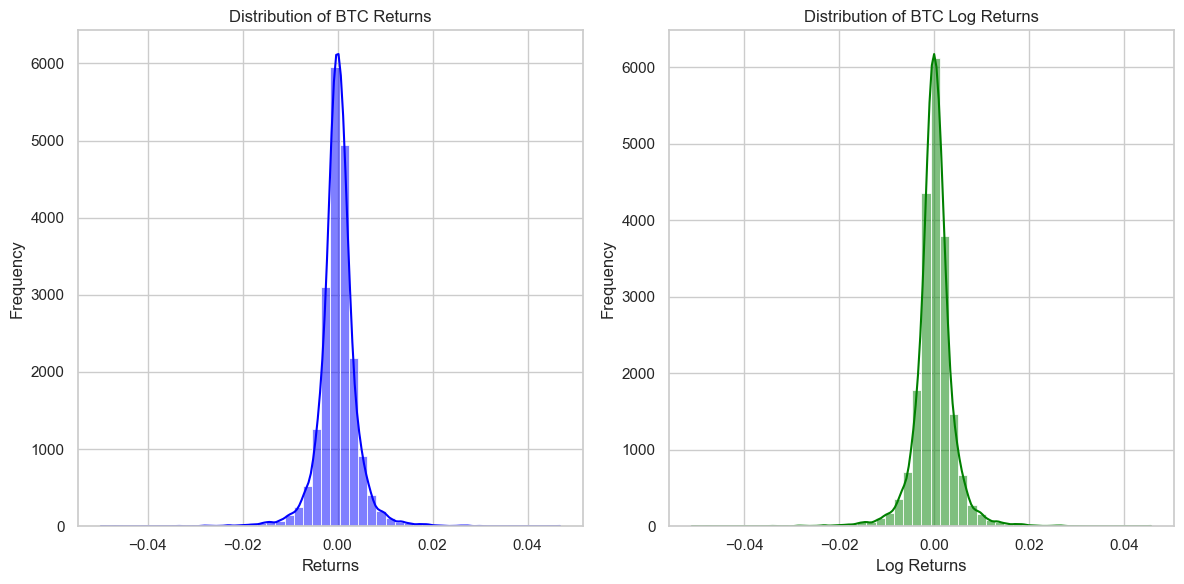

In [188]:
#plot distribution of btc[returns] and btc["log_returns"]
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot the distribution of 'returns'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(btc['returns'], kde=True, color='blue', bins=50)
plt.title('Distribution of BTC Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Plot the distribution of 'log_returns'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(btc['log_returns'], kde=True, color='green', bins=50)
plt.title('Distribution of BTC Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [190]:
#check the number of observations from spy
num_observations_spy

3835

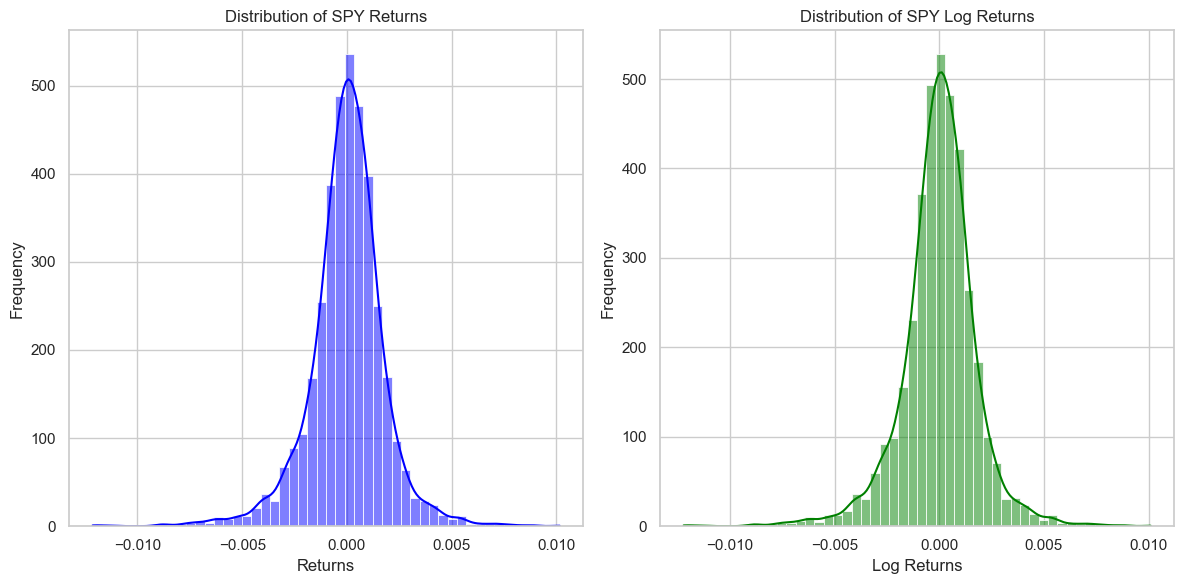

In [191]:
#plot distribution of spy[returns] and spy["log_returns"]
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot the distribution of 'returns'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(spy['returns'], kde=True, color='blue', bins=50)
plt.title('Distribution of SPY Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')

# Plot the distribution of 'log_returns'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(spy['log_returns'], kde=True, color='green', bins=50)
plt.title('Distribution of SPY Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## BTC prediction with rolling window

In [ ]:
# ignore march data for now
btc = btc[btc['Date'] < '2025-03-01']

print(len(btc[(btc['Date'] >= '2025-01-01') & (btc['Date'] < '2025-03-01')])) #2832 observations for training 

2832


In [196]:
test_size = 2832

# Features and Target Varaible
target = 'log_returns'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

test_date = btc.iloc[-test_size:]['Date']

# Split data into training and testing sets
X = btc[features]
y = btc[target]

# Use the specified window for training
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

window_size = 4800 # last 100 days of data
test_size = 2832 # Jan-Feb 2025

In [170]:
# Initialize lists to collect predictions
predictions2 = []

# Loop over the rolling window
for i in range(2151, test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions2.append(y_pred[0])

KeyboardInterrupt: 

In [ ]:
result_df_btc = pd.DataFrame(test_date)
result_df_btc['Actual'] = y_test  # Add actual values
result_df_btc['Predicted'] = predictions2  # Add predicted values
result_df_btc['PrevClose'] = X_test[['Close_lag1']]
result_df_btc['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]
result_df_btc["log_returns_lag1"] = X_test[['log_returns_lag1']]

ValueError: Length of values (681) does not match length of index (2832)

In [ ]:
result_df_btc

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
,,,,,
17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False
17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False
17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False
17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False
17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False
...,...,...,...,...,...
20366,2025-02-28 21:30:00,81465.09,82093.36098,80695.28,True
20367,2025-02-28 22:00:00,81785.98,82832.43628,81465.09,True
20368,2025-02-28 22:30:00,82054.27,82792.20484,81785.98,True


In [ ]:
result_df_btc.to_csv('../data/btc_rf_predictions_rolling_logfeatures.csv')

NameError: name 'result_df_btc' is not defined

## SPY prediction with rolling window

In [197]:
spy = spy.reset_index()
# ignore march data for now
spy = spy[spy['Date'] < '2025-03-01']

In [198]:
len(spy[(spy['Date'] >= '2025-01-01') & (spy['Date'] < '2025-03-01')])

507

In [199]:
# Features and Target Varaible
target = 'log_returns'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features

X = spy[features]
y = spy[target]

window_size = 1300 # last 100 days of data (approximately)
test_size = 507 # Jan-Feb 2025

test_date = spy.iloc[-test_size:]['Date']
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

In [ ]:
# Initialize lists to collect predictions
predictions_spy = []

# Loop over the rolling window
for i in range(test_size):
    # Define the training window
    start = len(X) - test_size - window_size + i
    end = len(X) - test_size + i
    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    # Create and fit the model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        max_features=10
    )
    rf_model.fit(X_train, y_train)

    # Predict the next 30 minutes
    y_pred = rf_model.predict(X.iloc[end:end + 1])
    predictions_spy.append(y_pred[0])

In [ ]:
results_df_spy = pd.DataFrame(test_date)
results_df_spy['Actual'] = y_test  # Add actual values
results_df_spy['Predicted'] = predictions_spy  # Add predicted values
results_df_spy['PrevClose'] = X_test[['Close_lag1']]
results_df_spy['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]
results_df_spy

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
3237,2025-01-01 00:00:00,586.900,588.502670,588.730,False
3238,2025-01-01 00:30:00,587.060,586.968758,586.900,False
3239,2025-01-01 01:00:00,585.860,587.495580,587.060,False
3240,2025-01-01 01:30:00,587.205,585.988060,585.860,False
3241,2025-01-01 02:00:00,584.960,586.748484,587.205,False
...,...,...,...,...,...
3739,2025-02-28 04:00:00,586.680,588.014102,589.185,False
3740,2025-02-28 04:30:00,585.130,587.134674,586.680,False
3741,2025-02-28 22:30:00,585.835,586.081226,585.130,False
3742,2025-02-28 23:00:00,588.250,586.202982,585.835,False


In [ ]:
results_df_spy.to_csv('../data/spy_rf_predictions_rolling_logfeatures.csv')

### trading result using btc rolling window with window size of past 100 trading days

In [ ]:
btc_preds = pd.read_csv('../data/btc_rf_predictions_rolling.csv')

In [17]:
#merge the two dfs tgt based on Date
results_df2 = btc_preds

In [18]:
# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.001
trading_results2 = results_df2.copy().reset_index(drop=True)
initial_btc_price = trading_results2['Actual'].iloc[0]
btc_units = initial_investment / initial_btc_price
cash = 10000 # All money is initially in BTC

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results2['Predicted_Diff'] = trading_results2['Predicted']/trading_results2['PrevClose'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results2['Signal'] = 0
trading_results2.loc[(trading_results2['Predicted_Diff'] > 0.0024) & (trading_results2['BreakHigh2_lag1']), 'Signal'] = 1
trading_results2.loc[trading_results2['Predicted_Diff'] < -0.0024, 'Signal'] = 0

# Initialize portfolio value columns
trading_results2['BTC_Units'] = 0
trading_results2['Cash'] = 0
trading_results2['Portfolio_Value'] = 0

# Track position changes
trading_results2['Position_Change'] = trading_results2['Signal'].diff().abs()

# Simulate trading
for i in range(len(trading_results)):
    current_price = trading_results2['Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]
        
    # First row initialization
    if i == 0:
        trading_results2.at[i, 'BTC_Units'] = btc_units
        trading_results2.at[i, 'Cash'] = cash
        trading_results2.at[i, 'Portfolio_Value'] = btc_units * current_price
        continue
        
    prev_signal = trading_results2['Signal'].iloc[i-1]
    prev_btc = trading_results2['BTC_Units'].iloc[i-1]
    prev_cash = trading_results2['Cash'].iloc[i-1]
        
    # If signal changed, execute a trade
    if current_signal != prev_signal:
        if current_signal == 1:  # Buy BTC
            # Calculate commission
            commission = prev_cash * commission_rate
            # Convert cash to BTC
            new_btc = (prev_cash - commission) / current_price
            btc_units = prev_btc + new_btc
            cash = 0
        else:  # Sell BTC
            # Calculate commission
            commission = (prev_btc * current_price) * commission_rate
            # Convert BTC to cash
            cash = (prev_btc * current_price) - commission
            btc_units = 0
    else:
        # No change in position
        btc_units = prev_btc
        cash = prev_cash
        
    # Update portfolio value
    portfolio_value = (btc_units * current_price) + cash
        
    # Store values
    trading_results2.at[i, 'BTC_Units'] = btc_units
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

C:\Users\jessi\AppData\Local\Temp\ipykernel_17164\581488215.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0546379443756526' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'BTC_Units'] = btc_units
C:\Users\jessi\AppData\Local\Temp\ipykernel_17164\581488215.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99999.99999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Portfolio_Value'] = btc_units * current_price
C:\Users\jessi\AppData\Local\Temp\ipykernel_17164\581488215.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '114791.68943572018' has dtype incompatible with int64, please explicitly cast

In [19]:
# Calculate buy & hold strategy for comparison
initial_btc = initial_investment / trading_results2['Actual'].iloc[0]
trading_results2['Buy_Hold_Value'] = initial_btc * trading_results2['Actual']
    
# Calculate returns and metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment) - 1
num_trades = trading_results2['Position_Change'].sum()

In [20]:
trading_results2

,Unnamed: 0,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1,Predicted_Diff,Signal,BTC_Units,Cash,Portfolio_Value,Position_Change,Buy_Hold_Value
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False,-0.002966,0,1.054638,10000.0,100000.000000,NaN,100000.000000
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False,-0.001843,0,1.054638,10000.0,109861.526038,0.0,99861.526038
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False,0.000656,0,1.054638,10000.0,109514.370866,0.0,99514.370866
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False,-0.000215,0,1.054638,10000.0,109095.563592,0.0,99095.563592
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False,-0.001050,0,1.054638,10000.0,108963.122159,0.0,98963.122159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,20366,2025-02-28 21:30:00,81465.09,82093.36098,80695.28,True,0.017325,1,1.395114,0.0,113653.079093,1.0,85916.175056
2828,20367,2025-02-28 22:00:00,81785.98,82832.43628,81465.09,True,0.016784,1,1.395114,0.0,114100.757191,0.0,86254.597826
2829,20368,2025-02-28 22:30:00,82054.27,82792.20484,81785.98,True,0.012303,1,1.395114,0.0,114475.052298,0.0,86537.546640
2830,20369,2025-02-28 23:00:00,84317.02,83402.23912,82054.27,True,0.016428,1,1.395114,0.0,117631.846266,0.0,88923.928649


### trading result using btc rolling window, spy rolling window, tlt and cash with window size of past 100 trading days

In [10]:
spy = pd.read_csv("../data/spy_rf_predictions_rolling.csv")
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name = "TLT - iShares 20+ Year Bond")
btc = pd.read_csv("../data/btc_rf_predictions_rolling.csv")

In [11]:
#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

# Print the new column names to verify
print(df_spy.columns)

Index(['Unnamed: 0', 'Date', 'SPY_Actual', 'SPY_Predicted', 'SPY_PrevClose',
       'SPY_BreakHigh2_lag1'],
      dtype='object')


In [12]:
#rename btc columns
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])

# Print the new column names to verify
print(df_btc.columns) 

Index(['Unnamed: 0', 'Date', 'BTC_Actual', 'BTC_Predicted', 'BTC_PrevClose',
       'BTC_BreakHigh2_lag1'],
      dtype='object')


In [13]:
### rename the TLT columns

columns = tlt.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'TLT_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_tlt = tlt.rename(columns=rename_dict)

df_tlt["Date"] = pd.to_datetime(df_tlt["Date"])

# Print the new column names to verify
print(df_tlt.columns) 

Index(['Date', 'TLT_Open', 'TLT_High', 'TLT_Low', 'TLT_Close',
       'TLT_SMAVG (5)  on Close', 'TLT_SMAVG (10)  on Close',
       'TLT_SMAVG (15)  on Close', 'TLT_Volume', 'TLT_SMAVG (5)'],
      dtype='object')


In [14]:
#merge all the dfs tgt
df = pd.merge(df_btc, df_spy, on = "Date", how = "left")
df_combined = pd.merge(df, df_tlt, on = "Date", how = "left")

In [15]:
df_combined.head()

,Unnamed: 0_x,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,BTC_BreakHigh2_lag1,Unnamed: 0_y,SPY_Actual,SPY_Predicted,SPY_PrevClose,SPY_BreakHigh2_lag1,TLT_Open,TLT_High,TLT_Low,TLT_Close,TLT_SMAVG (5) on Close,TLT_SMAVG (10) on Close,TLT_SMAVG (15) on Close,TLT_Volume,TLT_SMAVG (5)
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False,3237.0,586.900,588.502670,588.730,False,88.065,88.065,87.56,87.570,87.961,87.902,87.863,1463486.0,2993670.0
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False,3238.0,587.060,586.968758,586.900,False,87.570,87.650,87.48,87.575,87.916,87.876,87.847,2488418.0,1716545.0
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False,3239.0,585.860,587.495580,587.060,False,87.575,87.585,87.34,87.525,87.771,87.842,87.829,1582935.0,1724840.0
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False,3240.0,587.205,585.988060,585.860,False,87.530,87.765,87.43,87.610,87.669,87.818,87.821,3499756.0,2161849.0
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False,3241.0,584.960,586.748484,587.205,False,87.610,87.635,87.39,87.422,87.540,87.773,87.799,1925135.0,2191946.0


In [16]:
#save the df_combined to another csv
df_combined.to_csv("../data/df_combined_trading.csv")

## Old attempt

### BTC predictionw without rolling window

In [ ]:
btc = btc.reset_index()

# ignore march data for now
btc = btc[btc['Date'] < '2025-03-01']

print(len(btc[(btc['Date'] >= '2025-01-01') & (btc['Date'] < '2025-03-01')]))

test_size = 2832

# Features and Target Varaible
target = 'log_returns'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

test_date = btc.iloc[-test_size:]['Date']

# Split data into training and testing sets
X = btc[features]
y = btc[target]

# Use the specified window for training
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

2832


In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    max_features=10
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
results_df = pd.DataFrame(test_date)
results_df['Actual'] = y_test  # Add actual values
results_df['Predicted'] = y_pred  # Add predicted values
results_df['PrevClose'] = X_test[['Close_lag1']]
results_df['BreakHigh2_lag1'] = X_test[['BreakHigh2_lag1']]
results_df

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1
17539,2025-01-01 00:00:00,94819.27,95378.5272,95282.72,False
17540,2025-01-01 00:30:00,94687.97,94919.0775,94819.27,False
17541,2025-01-01 01:00:00,94358.80,94829.7986,94687.97,False
17542,2025-01-01 01:30:00,93961.69,94449.8533,94358.80,False
17543,2025-01-01 02:00:00,93836.11,93894.3826,93961.69,False
...,...,...,...,...,...
20366,2025-02-28 21:30:00,81465.09,82468.1581,80695.28,True
20367,2025-02-28 22:00:00,81785.98,82234.1110,81465.09,True
20368,2025-02-28 22:30:00,82054.27,82993.3490,81785.98,True
20369,2025-02-28 23:00:00,84317.02,82835.2985,82054.27,True


In [ ]:
results_df.to_csv('../data/btc_rf_predictions_wo_rolling.csv')

In [ ]:
# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.001
trading_results = results_df.copy().reset_index(drop=True)
initial_btc_price = trading_results['Actual'].iloc[0]
btc_units = initial_investment / initial_btc_price
cash = 0 # All money is initially in BTC

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results['Predicted_Diff'] = trading_results['Predicted']/trading_results['PrevClose'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results['Signal'] = 0
trading_results.loc[(trading_results['Predicted_Diff'] > 0.0023) & (trading_results['BreakHigh2_lag1']), 'Signal'] = 1
trading_results.loc[trading_results['Predicted_Diff'] < -0.0023, 'Signal'] = 0

# Initialize portfolio value columns
trading_results['BTC_Units'] = 0
trading_results['Cash'] = 0
trading_results['Portfolio_Value'] = 0

# Track position changes
trading_results['Position_Change'] = trading_results['Signal'].diff().abs()

# Simulate trading
for i in range(len(trading_results)):
    current_price = trading_results['Actual'].iloc[i]
    current_signal = trading_results['Signal'].iloc[i]
        
    # First row initialization
    if i == 0:
        trading_results.at[i, 'BTC_Units'] = btc_units
        trading_results.at[i, 'Cash'] = cash
        trading_results.at[i, 'Portfolio_Value'] = btc_units * current_price
        continue
        
    prev_signal = trading_results['Signal'].iloc[i-1]
    prev_btc = trading_results['BTC_Units'].iloc[i-1]
    prev_cash = trading_results['Cash'].iloc[i-1]
        
    # If signal changed, execute a trade
    if current_signal != prev_signal:
        if current_signal == 1:  # Buy BTC
            # Calculate commission
            commission = prev_cash * commission_rate
            # Convert cash to BTC
            new_btc = (prev_cash - commission) / current_price
            btc_units = prev_btc + new_btc
            cash = 0
        else:  # Sell BTC
            # Calculate commission
            commission = (prev_btc * current_price) * commission_rate
            # Convert BTC to cash
            cash = (prev_btc * current_price) - commission
            btc_units = 0
    else:
        # No change in position
        btc_units = prev_btc
        cash = prev_cash
        
    # Update portfolio value
    portfolio_value = (btc_units * current_price) + cash
        
    # Store values
    trading_results.at[i, 'BTC_Units'] = btc_units
    trading_results.at[i, 'Cash'] = cash
    trading_results.at[i, 'Portfolio_Value'] = portfolio_value

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_53480/121543288.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0546379443756526' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'BTC_Units'] = btc_units
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_53480/121543288.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99999.99999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Portfolio_Value'] = btc_units * current_price
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_53480/121543288.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99950.37181788047' has dtype incom

In [ ]:
# Calculate buy & hold strategy for comparison
initial_btc = initial_investment / trading_results['Actual'].iloc[0]
trading_results['Buy_Hold_Value'] = initial_btc * trading_results['Actual']
    
# Calculate returns and metrics
total_return = (trading_results['Portfolio_Value'].iloc[-1] / initial_investment) - 1
num_trades = trading_results['Position_Change'].sum()

In [ ]:
trading_results

,Date,Actual,Predicted,PrevClose,BreakHigh2_lag1,Predicted_Diff,Signal,BTC_Units,Cash,Portfolio_Value,Position_Change,Buy_Hold_Value
0,2025-01-01 00:00:00,94819.27,95378.5272,95282.72,False,0.001006,0,1.054638,0.0,100000.000000,NaN,100000.000000
1,2025-01-01 00:30:00,94687.97,94919.0775,94819.27,False,0.001053,0,1.054638,0.0,99861.526038,0.0,99861.526038
2,2025-01-01 01:00:00,94358.80,94829.7986,94687.97,False,0.001498,0,1.054638,0.0,99514.370866,0.0,99514.370866
3,2025-01-01 01:30:00,93961.69,94449.8533,94358.80,False,0.000965,0,1.054638,0.0,99095.563592,0.0,99095.563592
4,2025-01-01 02:00:00,93836.11,93894.3826,93961.69,False,-0.000716,0,1.054638,0.0,98963.122159,0.0,98963.122159
...,...,...,...,...,...,...,...,...,...,...,...,...
2827,2025-02-28 21:30:00,81465.09,82468.1581,80695.28,True,0.021970,1,1.187328,0.0,96725.750021,1.0,85916.175056
2828,2025-02-28 22:00:00,81785.98,82234.1110,81465.09,True,0.009440,1,1.187328,0.0,97106.751575,0.0,86254.597826
2829,2025-02-28 22:30:00,82054.27,82993.3490,81785.98,True,0.014763,1,1.187328,0.0,97425.299698,0.0,86537.546640
2830,2025-02-28 23:00:00,84317.02,82835.2985,82054.27,True,0.009518,1,1.187328,0.0,100111.925231,0.0,88923.928649


### BTC and SPY prediction with rolling window cv (nested loop)

In [ ]:
window_size = 3498  # Training window (1st jan 2024 - 31st dec 2024)
test_size = 3745-3498      # Testing window (1st jan - 28 feb 2025)

# Features and Target Variable
target = 'Close'
features = [col for col in btc.columns if 'lag' in col]  # Select only lagged features

In [ ]:
# Define Rolling Window Parameters
window_size = 3498  # Training window: 1st Jan 2024 - 31st Dec 2024
test_size = 3745 - 3498  # Testing window: 1st Jan - 28th Feb 2025
param_grid = [100, 200, 500]  # Hyperparameter tuning (number of trees)

# Features and Target Variable
target = "Close"
features = [col for col in btc.columns if "lag" in col]  # Select only lagged features
max_features_value = max(1, int(len(features) / 3))  # Ensure at least 1 feature

# Initialize storage for predictions and results
test_dates = btc.iloc[-test_size:]["DATE"].values
predictions_df = pd.DataFrame({"date": test_dates, "pred": np.nan})

# Rolling Window Loop
for start in range(len(btc) - window_size - test_size + 1):
    # Define rolling train and test sets
    train_data = btc.iloc[start : start + window_size]
    test_data = btc.iloc[start + window_size : start + window_size + 1]  # Predict next step

    if test_data.empty:
        break  # Stop if no more test data left

    # Extract X and y
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Nested Cross-Validation (Tuning n_estimators)
    best_n_estimators = None
    lowest_rmse = float("inf")

    for n_estimators in param_grid:
        inner_rmse = []

        for inner_start in range(0, len(X_train) - test_size, test_size):
            X_inner_train = X_train[inner_start : inner_start + (window_size - test_size)]
            X_inner_val = X_train[inner_start + (window_size - test_size) : inner_start + window_size]
            y_inner_train = y_train.iloc[inner_start : inner_start + (window_size - test_size)]
            y_inner_val = y_train.iloc[inner_start + (window_size - test_size) : inner_start + window_size]

            if len(X_inner_train) == 0 or len(X_inner_val) == 0:
                continue  # Skip invalid splits

            model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_features=max_features_value)
            model.fit(X_inner_train, y_inner_train)
            y_inner_pred = model.predict(X_inner_val)
            rmse = np.sqrt(mean_squared_error(y_inner_val, y_inner_pred))
            inner_rmse.append(rmse)

        if inner_rmse:
            mean_rmse = np.mean(inner_rmse)

            # Select best n_estimators
            if mean_rmse < lowest_rmse:
                lowest_rmse = mean_rmse
                best_n_estimators = n_estimators

    # Ensure a valid hyperparameter was selected
    if best_n_estimators is None:
        raise ValueError("Hyperparameter tuning failed. No valid n_estimators selected.")

    # Train final model with best hyperparameters
    best_model_btc = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42, max_features=max_features_value)
    best_model_btc.fit(X_train, y_train)

    # Predict and store result
    predictions_df.iloc[start, 1] = best_model.predict(X_test)[0]

# Merge Predictions with BTC Data
btc.loc[btc["DATE"].isin(predictions_df["date"]), "Predicted_Close"] = predictions_df["pred"]

# Calculate RMSE
actuals = btc.loc[btc["DATE"].isin(predictions_df["date"]), target]
mse = mean_squared_error(actuals, predictions_df["pred"])
rmse = np.sqrt(mse)

# Print final results
print(f"Optimal n_estimators for BTC: {best_n_estimators}")
print(f"RMSE BTC (Rolling Window): {rmse:.4f}")

In [ ]:
btc.to_csv("btc_preds.csv")

In [ ]:
#plot the feature importance
# Get the feature importances from the best model
importances = best_model_btc.feature_importances_

# Create a DataFrame with feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting BTC Closing Price')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

### Train random forest for SPY

In [ ]:
window_size = 3238  # Training window (Jan - Dec 2024)
test_size = 3745-3238 # Testing window (Jan-Feb 2025)

# Features and Target Variable
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features

In [ ]:
# Features and Target Variable
target = 'Close'
features = [col for col in spy.columns if 'lag' in col]  # Select only lagged features
max_features_value = int(len(features) / 3)  # Define max_features value

# Perform Nested Rolling Window Cross-Validation
predictions = []
actuals = []
test_indices = []

for start in range(0, len(spy) - window_size - test_size, test_size):
    # Outer Loop: Train/Test Split with Rolling Window
    train = spy.iloc[start : start + window_size]
    test = spy.iloc[start + window_size : start + window_size + test_size]

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Inner Loop: Hyperparameter tuning using a rolling window approach
    best_n_estimators = None
    lowest_rmse = float('inf')

    for n_estimators in param_grid:
        inner_rmse = []

        for inner_start in range(0, len(X_train) - window_size, test_size):
            X_inner_train = X_train[inner_start : inner_start + window_size]
            X_inner_val = X_train[inner_start + window_size : inner_start + window_size + test_size]
            y_inner_train = y_train.iloc[inner_start : inner_start + window_size]
            y_inner_val = y_train.iloc[inner_start + window_size : inner_start + window_size + test_size]

            # Train and validate model
            model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_features=max_features_value)
            model.fit(X_inner_train, y_inner_train)
            y_inner_pred = model.predict(X_inner_val)
            rmse = np.sqrt(mean_squared_error(y_inner_val, y_inner_pred))
            inner_rmse.append(rmse)

        # Compute average RMSE over inner folds
        mean_rmse = np.mean(inner_rmse)

        # Select best n_estimators based on RMSE
        if mean_rmse < lowest_rmse:
            lowest_rmse = mean_rmse
            best_n_estimators = n_estimators

    # Train final model with best hyperparameters
    best_model_spy = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42, max_features=max_features_value)
    best_model_spy.fit(X_train, y_train)

    # Predict on test set
    y_pred = best_model_spy.predict(X_test)
    predictions.extend(y_pred)
    actuals.extend(y_test)
    test_indices.extend(test.index)  # Save test indices for mapping

# Map predictions back to the original BTC dataframe
spy.loc[test_indices, 'Predicted_Close'] = predictions

# Calculate overall RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

# Print best hyperparameter and RMSE
print(f'Optimal n_estimators for SPY: {best_n_estimators}')
print(f'RMSE SPY: {rmse:.4f}')

In [ ]:
spy.to_csv("spy_preds.csv")

In [ ]:
#plot the feature importance
# Get the feature importances from the best model
importances = best_model_spy.feature_importances_

# Create a DataFrame with feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting SPY Closing Price')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()